In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [36]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
from torchvision.models import vgg16
import kagglehub

In [21]:
path = kagglehub.dataset_download("apollo2506/landuse-scene-classification")
data_path = os.path.join(path, "images_train_test_val")

In [22]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [23]:
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")
validation_path = os.path.join(data_path, "validation")

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)
validation_dataset = datasets.ImageFolder(root=validation_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

In [24]:
class HVAE(nn.Module):
    def __init__(self, latent_dim1=64, latent_dim2=32):
        super(HVAE, self).__init__()
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu2 = nn.Linear(128 * 16 * 16, latent_dim2)
        self.fc_logvar2 = nn.Linear(128 * 16 * 16, latent_dim2)

        self.fc_mu1 = nn.Linear(latent_dim2, latent_dim1)
        self.fc_logvar1 = nn.Linear(latent_dim2, latent_dim1)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim1, 128 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 16, 16)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # 128x128
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        enc = self.encoder(x)

        mu2, logvar2 = self.fc_mu2(enc), self.fc_logvar2(enc)
        z2 = self.reparameterize(mu2, logvar2)

        mu1, logvar1 = self.fc_mu1(z2), self.fc_logvar1(z2)
        z1 = self.reparameterize(mu1, logvar1)

        x_recon = self.decoder(self.decoder_input(z1))
        return x_recon, mu1, logvar1, mu2, logvar2

In [25]:
def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def loss_function(recon_x, x, mu1, logvar1, mu2, logvar2):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KL1 = kl_divergence(mu1, logvar1)
    KL2 = kl_divergence(mu2, logvar2)
    return BCE + KL1 + KL2

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(model, loader, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for imgs, _ in loader:
            imgs = imgs.to(device)
            optimizer.zero_grad()
            recon, mu1, logvar1, mu2, logvar2 = model(imgs)
            loss = loss_function(recon, imgs, mu1, logvar1, mu2, logvar2)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss / len(loader.dataset):.4f}")

train(model, train_loader, epochs=10)

Epoch [1/10] Loss: 2675.5944
Epoch [2/10] Loss: 1736.6699
Epoch [3/10] Loss: 1530.3971
Epoch [4/10] Loss: 1445.7157
Epoch [5/10] Loss: 1396.2220
Epoch [6/10] Loss: 1358.1294
Epoch [7/10] Loss: 1328.5047
Epoch [8/10] Loss: 1304.9869
Epoch [9/10] Loss: 1281.9447
Epoch [10/10] Loss: 1268.9216


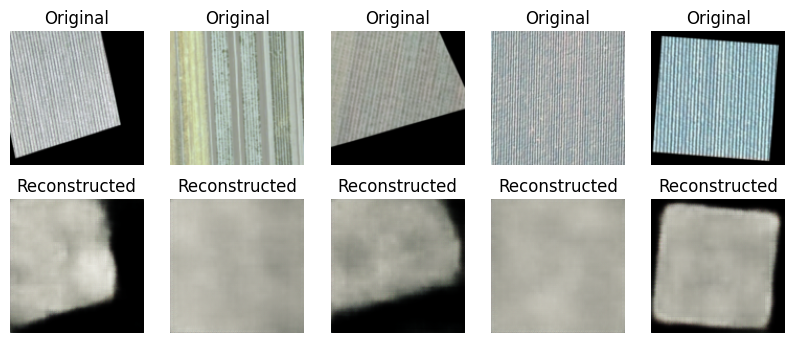

In [27]:
def visualize_reconstruction(model, loader):
    model.eval()
    with torch.no_grad():
        imgs, _ = next(iter(loader))
        imgs = imgs.to(device)
        recon, _, _, _, _ = model(imgs)

        imgs = imgs.cpu().numpy().transpose(0, 2, 3, 1)
        recon = recon.cpu().numpy().transpose(0, 2, 3, 1)

        plt.figure(figsize=(10, 4))
        for i in range(5):
            plt.subplot(2, 5, i+1)
            plt.imshow(imgs[i])
            plt.title("Original")
            plt.axis('off')

            plt.subplot(2, 5, i+6)
            plt.imshow(recon[i])
            plt.title("Reconstructed")
            plt.axis('off')
        plt.show()

visualize_reconstruction(model, test_loader)


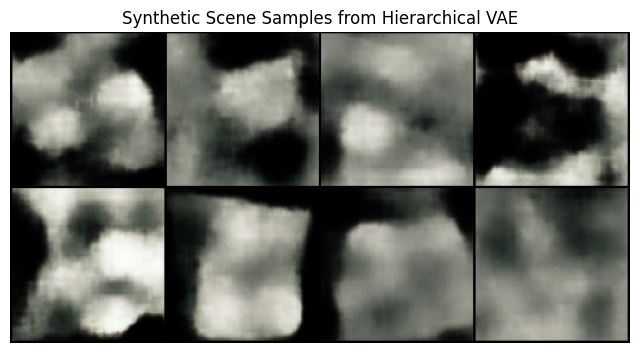

In [32]:
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr

def generate_synthetic_samples(model, n=8):
    model.eval()
    with torch.no_grad():
        z2 = torch.randn(n, model.latent_dim2).to(device)
        mu1 = model.fc_mu1(z2)
        logvar1 = model.fc_logvar1(z2)
        z1 = model.reparameterize(mu1, logvar1)
        decoded = model.decoder(model.decoder_input(z1))
        return decoded.cpu()

samples = generate_synthetic_samples(model)
grid = make_grid(samples, nrow=4).permute(1, 2, 0)
plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis('off')
plt.title("Synthetic Scene Samples from Hierarchical VAE")
plt.show()

In [34]:
def scene_realism_score(real_batch, recon_batch):
    scores = []
    for real, recon in zip(real_batch, recon_batch):
        real_np = real.permute(1, 2, 0).numpy()
        recon_np = recon.permute(1, 2, 0).numpy()

        real_gray = cv2.cvtColor((real_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        recon_gray = cv2.cvtColor((recon_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        ssim_score = ssim(real_gray, recon_gray)

        hist_real = cv2.calcHist([(real_np * 255).astype(np.uint8)], [0, 1, 2], None, [8, 8, 8], [0,256]*3).flatten()
        hist_recon = cv2.calcHist([(recon_np * 255).astype(np.uint8)], [0, 1, 2], None, [8, 8, 8], [0,256]*3).flatten()
        corr, _ = pearsonr(hist_real, hist_recon)

        score = 0.6 * ssim_score + 0.4 * corr
        scores.append(score)
    return np.mean(scores)

model.eval()
with torch.no_grad():
    val_imgs, _ = next(iter(validation_loader))
    val_imgs = val_imgs[:16].to(device)
    recon_val, *_ = model(val_imgs)

srs_score = scene_realism_score(val_imgs.cpu(), recon_val.cpu())
print(f"Scene Realism Score (SRS) on validation samples: {srs_score:.4f}")

Scene Realism Score (SRS) on validation samples: 0.4083


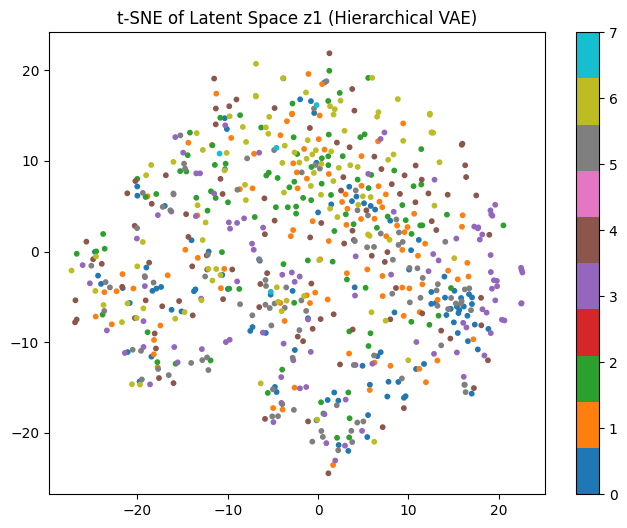

In [35]:
def visualize_latent_space(model, loader):
    model.eval()
    z1_list, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            enc = model.encoder(imgs)
            mu2 = model.fc_mu2(enc)
            z2 = model.reparameterize(mu2, model.fc_logvar2(enc))
            mu1 = model.fc_mu1(z2)
            z1 = model.reparameterize(mu1, model.fc_logvar1(z2))
            z1_list.append(z1.cpu().numpy())
            labels.extend(lbls.cpu().numpy())
            if len(z1_list) > 10:
                break

    z1_all = np.concatenate(z1_list, axis=0)
    tsne = TSNE(n_components=2, perplexity=30)
    z1_2d = tsne.fit_transform(z1_all)

    plt.figure(figsize=(8, 6))
    plt.scatter(z1_2d[:, 0], z1_2d[:, 1], c=labels[:len(z1_2d)], cmap='tab10', s=10)
    plt.colorbar()
    plt.title("t-SNE of Latent Space z1 (Hierarchical VAE)")
    plt.show()

visualize_latent_space(model, validation_loader)

In [37]:
class HVAE(nn.Module):
    def __init__(self, latent_dim1=128, latent_dim2=64):
        super(HVAE, self).__init__()
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu2 = nn.Linear(128 * 16 * 16, latent_dim2)
        self.fc_logvar2 = nn.Linear(128 * 16 * 16, latent_dim2)

        self.fc_mu1 = nn.Linear(latent_dim2, latent_dim1)
        self.fc_logvar1 = nn.Linear(latent_dim2, latent_dim1)

        self.decoder_input = nn.Linear(latent_dim1, 128 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 16, 16)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        enc = self.encoder(x)
        mu2, logvar2 = self.fc_mu2(enc), self.fc_logvar2(enc)
        z2 = self.reparameterize(mu2, logvar2)
        mu1, logvar1 = self.fc_mu1(z2), self.fc_logvar1(z2)
        z1 = self.reparameterize(mu1, logvar1)
        x_recon = self.decoder(self.decoder_input(z1))
        return x_recon, mu1, logvar1, mu2, logvar2


In [48]:
vgg_weights = torch.load("/kaggle/input/vggpath/vgg16-397923af.pth")
vgg = vgg16()
vgg.load_state_dict(vgg_weights)
vgg = vgg.features[:9].eval().to(device)

for p in vgg.parameters():
    p.requires_grad = False

def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def perceptual_loss(x, x_hat):
    x_vgg = vgg(x)
    x_hat_vgg = vgg(x_hat)
    return F.mse_loss(x_vgg, x_hat_vgg)

def loss_function(recon_x, x, mu1, logvar1, mu2, logvar2):
    mse = F.mse_loss(recon_x, x, reduction='sum')
    perceptual = perceptual_loss(recon_x, x) * 100
    KL1 = kl_divergence(mu1, logvar1)
    KL2 = kl_divergence(mu2, logvar2)
    return mse + perceptual + KL1 + KL2

/tmp/ipykernel_31/3335654615.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg_weights = torch.load("/kaggle/input/vggpath/vgg16-397923af.pth")


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(model, loader, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for imgs, _ in loader:
            imgs = imgs.to(device)
            optimizer.zero_grad()
            recon, mu1, logvar1, mu2, logvar2 = model(imgs)
            loss = loss_function(recon, imgs, mu1, logvar1, mu2, logvar2)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss / len(loader.dataset):.4f}")

train(model, train_loader, epochs=20)

Epoch [1/20] Loss: 2508.2884
Epoch [2/20] Loss: 1691.4802
Epoch [3/20] Loss: 1542.6121
Epoch [4/20] Loss: 1466.6635
Epoch [5/20] Loss: 1419.6074
Epoch [6/20] Loss: 1373.6346
Epoch [7/20] Loss: 1339.0885
Epoch [8/20] Loss: 1315.3773
Epoch [9/20] Loss: 1286.6597
Epoch [10/20] Loss: 1265.5451
Epoch [11/20] Loss: 1241.5256
Epoch [12/20] Loss: 1225.2814
Epoch [13/20] Loss: 1209.5717
Epoch [14/20] Loss: 1194.9206
Epoch [15/20] Loss: 1185.5271
Epoch [16/20] Loss: 1168.8514
Epoch [17/20] Loss: 1158.1999
Epoch [18/20] Loss: 1142.5827
Epoch [19/20] Loss: 1124.6510
Epoch [20/20] Loss: 1113.5888


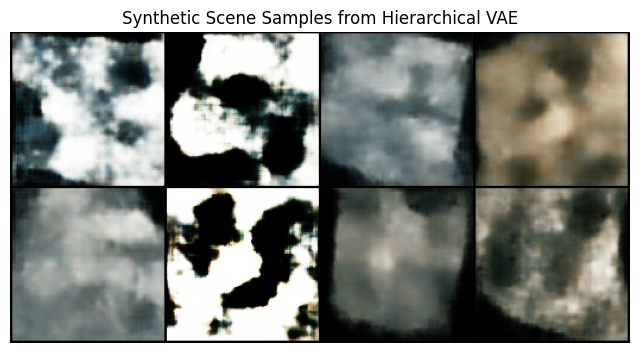

In [54]:
def generate_synthetic_samples(model, n=8):
    model.eval()
    with torch.no_grad():
        z2 = torch.randn(n, model.latent_dim2).to(device)
        mu1 = model.fc_mu1(z2)
        logvar1 = model.fc_logvar1(z2)
        z1 = model.reparameterize(mu1, logvar1)
        decoded = model.decoder(model.decoder_input(z1))
        return decoded.cpu()

samples = generate_synthetic_samples(model)
grid = make_grid(samples, nrow=4).permute(1, 2, 0)
plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis('off')
plt.title("Synthetic Scene Samples from Hierarchical VAE")
plt.show()

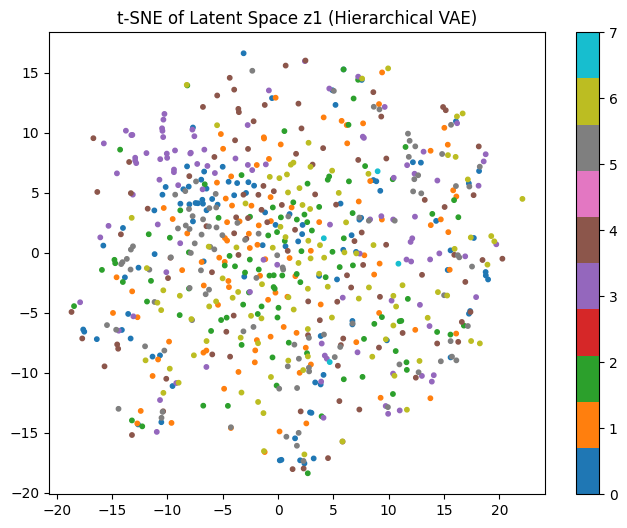

In [59]:
def visualize_latent_space(model, loader):
    model.eval()
    z1_list, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            enc = model.encoder(imgs)
            mu2 = model.fc_mu2(enc)
            z2 = model.reparameterize(mu2, model.fc_logvar2(enc))
            mu1 = model.fc_mu1(z2)
            z1 = model.reparameterize(mu1, model.fc_logvar1(z2))
            z1_list.append(z1.cpu().numpy())
            labels.extend(lbls.cpu().numpy())
            if len(z1_list) > 10:
                break

    z1_all = np.concatenate(z1_list, axis=0)
    tsne = TSNE(n_components=2, perplexity=30)
    z1_2d = tsne.fit_transform(z1_all)

    plt.figure(figsize=(8, 6))
    plt.scatter(z1_2d[:, 0], z1_2d[:, 1], c=labels[:len(z1_2d)], cmap='tab10', s=10)
    plt.colorbar()
    plt.title("t-SNE of Latent Space z1 (Hierarchical VAE)")
    plt.show()

visualize_latent_space(model, validation_loader)